In [34]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [35]:
logs_df = pd.read_csv('../loading_times.csv')
logs_df.head()

,layer_index,layer_name,loading_time
0,899,proposal_generator/Flatten_6_tl_flatten,4.66
1,900,proposal_generator/TopK_1_tl_topk_indices_cast,3.65
2,901,proposal_generator/TopK_1_tl_topk_output_shape,3.70
3,902,proposal_generator/Flatten_7_tl_flatten,3.81
4,903,proposal_generator/TopK_2_tl_topk_indices_cast,3.46


In [36]:
loading_times= logs_df['loading_time']

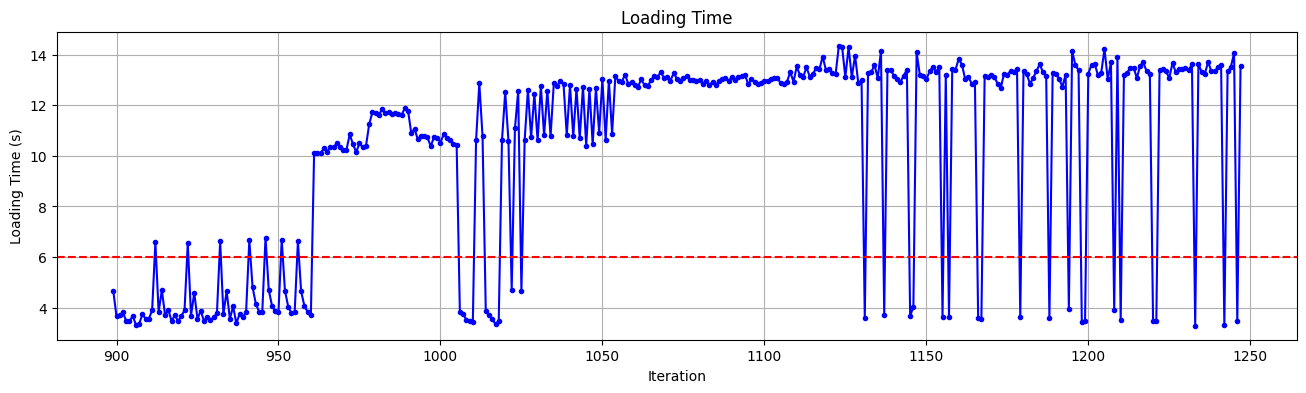

In [37]:
t_max = 6 # seconds

# plot loading times
plt.figure(figsize=(16, 4))
plt.plot(logs_df['layer_index'].to_numpy(), logs_df['loading_time'].to_numpy(), 'b-', label='Loading Time', marker='.')
plt.xlabel('Iteration')
plt.ylabel('Loading Time (s)')
plt.title('Loading Time')
plt.grid()
plt.axhline(y=t_max, color='r', linestyle='--', label='Threshold')

In [38]:
def analyze_layer_loading_times(df, threshold_std=2.5, min_time_diff=0.1):
    """
    Analyze layer loading times to detect suspicious spikes in performance.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns 'layer_name' and 'loading_time'
    threshold_std : float, optional
        Number of standard deviations to use as threshold for spike detection
    min_time_diff : float, optional
        Minimum time difference (in seconds) to consider as significant
        
    Returns:
    --------
    tuple
        (suspicious_layers_df, fig) containing the analysis results and visualization
    """
    # Calculate time differences between consecutive layers
    df = df.copy()
    df['time_diff'] = df['loading_time'].diff()
    
    # Replace first NaN with actual loading time
    df.loc[df.index[0], 'time_diff'] = df.loc[df.index[0], 'loading_time']
    
    # Calculate z-scores of time differences
    df['z_score'] = stats.zscore(df['time_diff'])
    
    # Identify suspicious layers based on both z-score and minimum time difference
    suspicious_mask = (np.abs(df['z_score']) > threshold_std) & (df['time_diff'] > min_time_diff)
    suspicious_layers = df[suspicious_mask].copy()
    
    # Sort suspicious layers by time difference magnitude
    suspicious_layers = suspicious_layers.sort_values('time_diff', ascending=False)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Convert data to numpy arrays for plotting
    x_points = np.arange(len(df))
    loading_times = df['loading_time'].to_numpy()
    time_diffs = df['time_diff'].to_numpy()
    
    # Plot 1: Cumulative loading time
    ax1.plot(x_points, loading_times, 'b-', label='Cumulative Loading Time', marker='.')
    if len(suspicious_layers) > 0:
        suspicious_indices = suspicious_layers.index.to_numpy()
        suspicious_times = suspicious_layers['loading_time'].to_numpy()
        ax1.scatter(suspicious_indices, suspicious_times, 
                   color='red', label='Suspicious Layers')
    ax1.set_xlabel('Layer Index')
    ax1.set_ylabel('Cumulative Time (s)')
    ax1.set_title('Layer Loading Time Analysis')
    ax1.legend()
    ax1.grid()
    
    # Plot 2: Time differences between layers
    ax2.plot(x_points, time_diffs, 'g-', label='Time Difference', marker='.')  
    if len(suspicious_layers) > 0:
        suspicious_diffs = suspicious_layers['time_diff'].to_numpy()
        ax2.scatter(suspicious_indices, suspicious_diffs,
                   color='red', label='Spikes')
    threshold_line = df['time_diff'].mean() + threshold_std * df['time_diff'].std()
    ax2.axhline(y=threshold_line, color='r', linestyle='--', 
                alpha=0.5, label='Upper Threshold')
    ax2.axhline(y=0, color='k', linestyle='-', 
                alpha=0.5)
    ax2.set_xlabel('Layer Index')
    ax2.set_ylabel('Time Difference (s)')
    ax2.set_title('Layer-to-Layer Time Differences')
    ax2.legend()
    
    plt.tight_layout()
    
    # Add layer names to the results
    if len(suspicious_layers) > 0:
        print("\nSuspicious layers detected:")
        print(suspicious_layers[['layer_name', 'time_diff', 'z_score']].to_string())
    else:
        print("\nNo suspicious layers detected with current thresholds.")
    
    return suspicious_layers, fig


Suspicious layers detected:
                                                      layer_name  time_diff   z_score
335          roi_heads/box_pooler/level_poolers.2/Shape_tl_shape      10.35  3.117758
296  roi_heads/box_pooler/level_poolers.0/RoiAlign_tl_roi_concat      10.21  3.075426
348  roi_heads/box_pooler/level_poolers.1/RoiAlign_tl_roi_concat      10.09  3.039142
248          roi_heads/box_pooler/level_poolers.0/Equal_tl_equal      10.07  3.033095
344      roi_heads/box_pooler/level_poolers.2/Gather_1_tl_gather      10.05  3.027048
310                                 tf.__operators__.getitem_131      10.02  3.017977
323                                           tf.math.subtract_5       9.93  2.990764
259                                 tf.__operators__.getitem_120       9.82  2.957504
301          roi_heads/box_pooler/level_poolers.1/Equal_tl_equal       9.79  2.948433
281          roi_heads/box_pooler/level_poolers.1/Shape_tl_shape       9.74  2.933314
233          roi_heads/bo

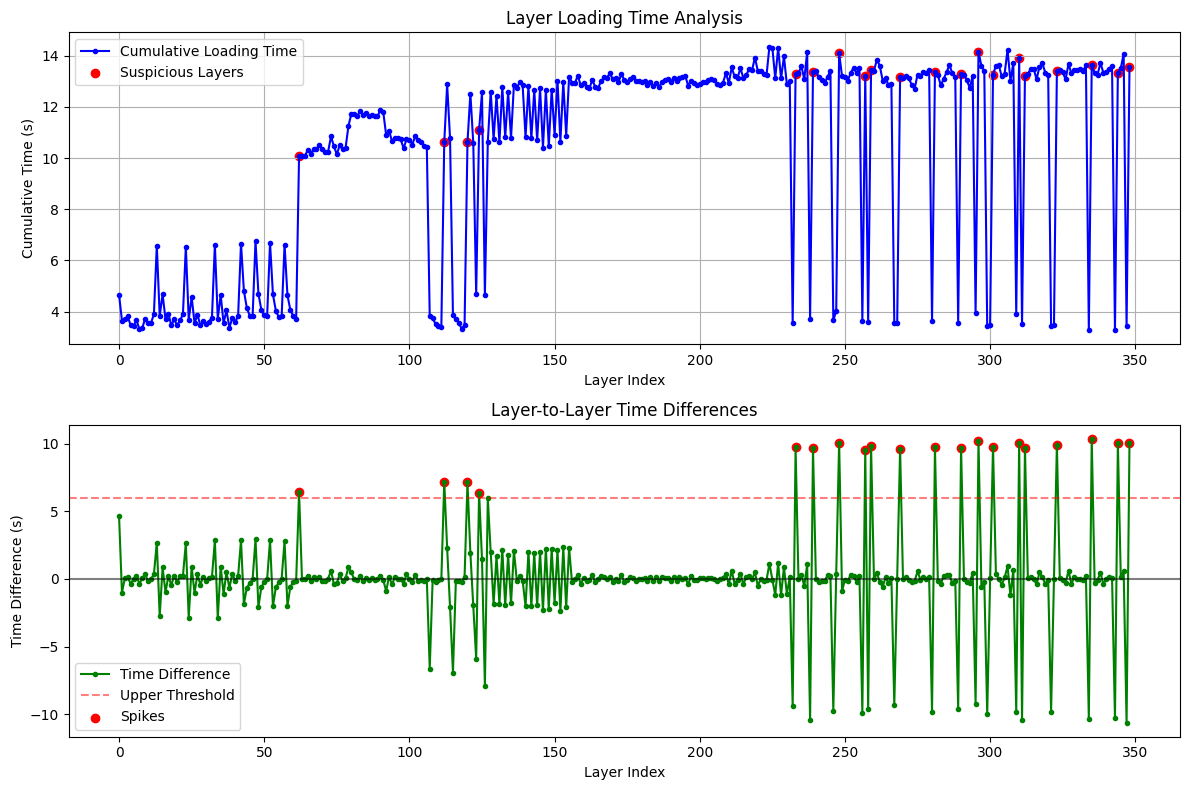

In [40]:
suspicious_layers, fig = analyze_layer_loading_times(logs_df, 1.8);
